###Package

In [2]:
!pip install langdetect

In [3]:
!pip install googletrans==4.0.0-rc1

In [4]:
!pip install Sastrawi

###Library

In [1]:
import pandas as pd
import re
import unicodedata
import string
from langdetect import detect
from googletrans import Translator
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect, DetectorFactory
from googletrans import Translator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Load dataset

In [3]:
df_comments = pd.read_csv('/content/drive/MyDrive/PemrosesanTeksTeori/Scraping_YT_histID.csv')
df_comments.head()

,comment_ori
0,Pemerintah kita tahun ini ngumumin adanya penu...
1,"jangan lupa bang, kasus di mana kaum mayoritas..."
2,"dulu ga zaman digital, susah nyimpen bukti. ha..."
3,Sekarang sudah diangkat menjadi pahlawan Nasional
4,Sejarah ditulis oleh pemenang


In [4]:
len(df_comments)

1026

###Inisialisasi stopword, stemmer, lemmatizer, Fungsi prefix

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer_en = WordNetLemmatizer()
stopwords_en = set(stopwords.words("english"))

factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
LEMMA_DICT = {"intah": "perintah", "ontak": "berontak", "pemerintah": "pemerintah", "pemerintahan": "pemerintah", "nyindir": "sindir",
              "nyimpen": "simpen", "nyimpan": "simpan", "nyontek": "sontek", "nyari": "cari", "ngomong": "omong", "sibapak": "bapak",
              "ngegas": "gas", "ngelakuin": "laku", "ngelaku": "laku", "ngebantai": "bantai", "ngumumin": "umum", "petrusnya": "petrus",
              "alasan": "alasan", "ilangin": "hilang", "dibohongin": "bohong", "ajarin": "ajar", "gedein": "gede", "kecilin": "kecil",
              "kedengeran": "dengar", "nyadarin": "sadar", "haluan": "halu", "dipoles": "poles", "pantesan": "pantas", "mendownload":
              "download", "diturunin": "turun", "jilatin": "jilat", "dipajakin": "pajak", "disembunyiin": "sembunyi", "diterapin": "terap",
              "keinget": "ingat", "lainnya": "lain", "bayangin": "bayang", "kelihatanya": "lihat", "membrontak": "brontak", "ngahapus": "hapus",
              "ngakalin": "akal", "direspon": "respon", "diperbaiki": "perbaiki", "disebutin": "sebut", "ngebahas": "bahas", "ngurusin": "urus",
              "pemenang": "menang", "pemenangnya": "menang"

}

STOPWORDS_ID = {"yang","sama","jadi","sudah","akan","kita","kalian","mereka","tapi","bahkan","bisa","coba","mungkin",
                "saya","kamu","banget","sangat","lebih","bukan","dari","pada","terlalu","sampai","tersebut","skrng",
                "orang","karena","kalau","untuk","dengan","dong","jangan","mana","juga","makasih","melakukan","videonya",
                "kayak","emang","memang","siapa","bagaimana","bagaiamana","soalnya","saja","atas","ingat","bjir","beuhh",
                "cuma","cuman","masih","gimana","lalu","kali","gini","sampe","biar","bikin","kebanyakan","terimakasih",
                "malah","tahu","makin","adalah","selalu","memiliki","paling","sering","dalam","bang","dilakukan","tiati",
                "hingga","ngak","terus","harus","membuat","adanya","sekali","semakin","melihat","gapernah","nihh","knpa",
                "gitu","bakal","telah","sungguh","menjadi","harap","tetapi","ingin","wkwkwk","wkwk","kdng","kyak","nnti",
                "tbtb","pnya","kontll","sbagai","aowkwkwkwokw","dpet","haha","kalaupun","brooo","a0akah","tidakmtakut",
                "meng","pdhl","sjarah","aduhh","wihh","mmng","adasih","nyernag","bruhh","bnget","kalo","huhu","lahh","adaa",
                "kenapasih","nggk","alamakk","alamak","makanya","hihihi","hadehh","wkwkwkwkwkwk","ituhh","ygkek","donk"
}

In [7]:
def fix_indonesian_prefix(word):

    # 1. Tangani "ny" prefix informal (ny + vokal / konsonan)
    if word.startswith("ny"):
        # ny + vokal (nyanyian -> anyian, nyeri -> eri)
        if len(word) > 2 and word[2] in "aiueo":
            return word[2:]

        # ny + konsonan (nyindir -> sindir)
        if len(word) > 2:
            return "s" + word[2:]

    # 2. Tangani "nge" prefix (ngebahas -> bahas)
    if word.startswith("nge"):
        if len(word) > 3:
            return word[3:]

    # 3. Tangani "ng" prefix umum (ngurus, ngomong)
    if word.startswith("ng"):
        if len(word) > 2:
            return word[2:]

    # 4. Tangani "di-...-in" (dibohongin, disembunyiin)
    if word.startswith("di") and word.endswith("in"):
        core = word[2:-2]
        return core

    # 5. Tangani "ke-...-in/kan" informal
    if word.startswith("ke") and (word.endswith("in") or word.endswith("kan")):
        return word[2:]

    # 6. Tangani "mem-" / "men-" / "meng-" / "meny-"
    if word.startswith(("mem", "men", "meng", "meny")):
        if len(word) > 4:
            return word[3:]  # buang mem- / men-
        if word.startswith("meng") and len(word) > 4:
            return word[4:]

    return word


###Stemming + lemmatization

In [8]:
def indonesian_stem_lemma(word):
    # 1. Sastrawi stem
    stemmed = stemmer_id.stem(word)

    # 2. Jika ada dalam kamus lemma → override
    if stemmed in LEMMA_DICT:
        return LEMMA_DICT[stemmed]

    # 3. Perbaikan prefix informal
    prefix_fixed = fix_indonesian_prefix(stemmed)

    # 4. Prefix hasil setelah diperbaiki masuk kamus
    if prefix_fixed in LEMMA_DICT:
        final_word = LEMMA_DICT[prefix_fixed]

    # 5. Jika kata original ada di kamus lemma
    if word in LEMMA_DICT:
        return LEMMA_DICT[word]

    return prefix_fixed


###Lemmatization Bahasa Inggris

In [9]:
def english_fallback(tokens):
    cleaned = []
    for w in tokens:
        if w not in stopwords_en:
            w = lemmatizer_en.lemmatize(w)
            cleaned.append(w)
    return cleaned


###Fungsi translate

In [10]:
def translate_to_indonesian(text):
    try:
        lang = detect_language(text)
        if lang == 'en':
            return translate_english_to_indonesian(text).lower()
        else:
            return text.lower()
    except:
        return text.lower()

###Preprocessing

In [11]:
def reduce_repeated_letters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [12]:
def preprocess_text(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    # 2. Lowercase
    text = text.lower()

    # 3. Clean URL, mentions, emoji, punctuation
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r"\s+", " ", text).strip()
    text = translate_to_indonesian(text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = reduce_repeated_letters(text)
    text = text.lower().strip()

    if len(text) == 0:
        return ""

    # 4. Tokenizing
    tokens = text.split()

    # 5. Stopwords
    tokens = [w for w in tokens if w not in STOPWORDS_ID]

    if len(tokens) == 0:
        return ""

    tokens = [w for w in tokens if len(w) > 3]

    # 6. Stemming + Lemmatization Indonesia
    processed = []
    for w in tokens:
        new_w = indonesian_stem_lemma(w)
        processed.append(new_w)

    # 7. Fallback English lemmatization
    processed = english_fallback(processed)

    # 8. Gabungkan kembali
    final_text = " ".join(processed).strip()

    return final_text

# hapus duplikat komentar
df_comments = df_comments.dropna(subset=["comment_ori"])
before = len(df_comments)
df_comments = df_comments.drop_duplicates(subset=["comment_ori"]).reset_index(drop=True)
after = len(df_comments)

df_comments["comment_clean"] = df_comments["comment_ori"].apply(preprocess_text)
df_comments.head()


,comment_ori,comment_clean
0,Pemerintah kita tahun ini ngumumin adanya penu...,pemerintah tahun umum tulis ulang buku sejarah...
1,"jangan lupa bang, kasus di mana kaum mayoritas...",lupa kasus kaum mayoritas negeri bantai kaum m...
2,"dulu ga zaman digital, susah nyimpen bukti. ha...",dulu zaman digital susah simpen bukti hanya li...
3,Sekarang sudah diangkat menjadi pahlawan Nasional,sekarang angkat pahlawan nasional
4,Sejarah ditulis oleh pemenang,sejarah tulis oleh menang


In [13]:
# eksport dataset
df_comments.to_csv('HistID_PRE.csv', index=False, encoding='utf-8')

###TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Ambil data bersih dan tidak kosong
cleaned_data = df_comments[df_comments['comment_clean'].str.strip() != '']['comment_clean']

vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1,2)
)

X_tfidf = vectorizer.fit_transform(cleaned_data)

# Feature names
terms = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=terms
)

tfidf_df.head()

,abad,abad kosong,absolute,ada,adab,adil,admin,agama,agar,agar tidak,...,wawas,well,wilayah,wowo,yahoedi,yahudi,yaitu,yakin,youtube,zaman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.115556,0.115556,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250372
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


###Elbow method

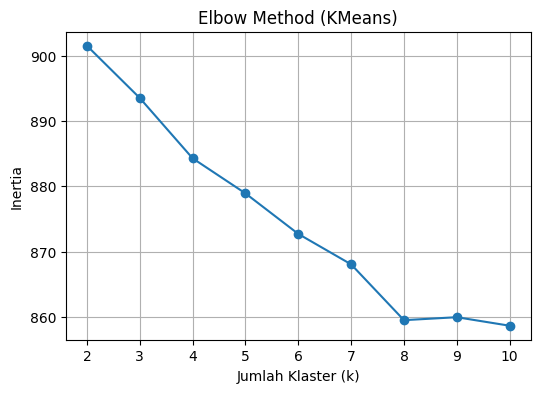

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Jumlah Klaster (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (KMeans)")
plt.grid(True)
plt.show()


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = {}

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    silhouette_scores[k] = score
    print(f"k = {k}, Silhouette Score = {score:.4f}")


k = 2, Silhouette Score = 0.0208
k = 3, Silhouette Score = 0.0224
k = 4, Silhouette Score = 0.0258
k = 5, Silhouette Score = 0.0275
k = 6, Silhouette Score = 0.0283
k = 7, Silhouette Score = 0.0299
k = 8, Silhouette Score = 0.0342
k = 9, Silhouette Score = 0.0318
k = 10, Silhouette Score = 0.0301


In [28]:
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("k terbaik berdasarkan Silhouette Score:", best_k)

k terbaik berdasarkan Silhouette Score: 8


###Topik modeling: BERTopik

In [32]:
from bertopic import BERTopic
from umap import UMAP
import numpy as np

k_optimal = best_k

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

kmeans_model = KMeans(
    n_clusters=k_optimal,
    random_state=42,
    n_init=10
)

topic_model = BERTopic(
    language="multilingual",
    umap_model=umap_model,
    hdbscan_model=kmeans_model,
    calculate_probabilities=True,
    verbose=True
)

docs = cleaned_data.tolist()
topics, probs = topic_model.fit_transform(docs)

# Total data adalah jumlah dokumen
total_data = len(docs)
# Menghitung jumlah titik noise (Topik -1)
data_as_noise = np.sum(np.array(topics) == -1)
# Menghitung data yang berhasil di-cluster (Topik >= 0)
data_in_clusters = total_data - data_as_noise


2025-12-17 06:47:38,537 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2025-12-17 06:48:17,489 - BERTopic - Embedding - Completed ✓
2025-12-17 06:48:17,490 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-17 06:48:20,931 - BERTopic - Dimensionality - Completed ✓
2025-12-17 06:48:20,932 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-17 06:48:20,969 - BERTopic - Cluster - Completed ✓
2025-12-17 06:48:20,973 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-17 06:48:21,003 - BERTopic - Representation - Completed ✓


In [33]:
total_data = len(docs)
n_clusters = len(set(topics))

print("## Hasil BERTopic (KMeans)")
print(f"Total Dokumen        : {total_data}")
print(f"Dokumen Berhasil di-Cluster (Topik Terbentuk): {data_in_clusters} dokumen")
print(f"Jumlah Topik         : {n_clusters}")
print(f"Semua data tercluster: YA (tanpa noise)")

## Hasil BERTopic (KMeans)
Total Dokumen        : 982
Dokumen Berhasil di-Cluster (Topik Terbentuk): 982 dokumen
Jumlah Topik         : 8
Semua data tercluster: YA (tanpa noise)


In [38]:
from sklearn.metrics import silhouette_score

# Embedding UMAP
umap_embeddings = topic_model.umap_model.embedding_

sil_score = silhouette_score(
    umap_embeddings,
    topics
)

print(f"Silhouette Score (UMAP embedding): {sil_score:.4f}")


Silhouette Score (UMAP embedding): 0.5585


In [43]:
print("\nInfo Topik (Top 5):")
topic_info = topic_model.get_topic_info()
print(topic_info)


Info Topik (Top 5):
   Topic  Count                                Name  \
0      0    317           0_keren_kobi_suara_kenapa   
1      1    231           1_sejarah_ajar_buku_tulis   
2      2    164  2_indonesia_sejarah_negara_amerika   
3      3     91  3_pemerintah_negara_demokrasi_baik   
4      4     78             4_atau_kuasa_tidak_cara   
5      5     52             5_video_guy_vidio_bagus   
6      6     30       6_animasi_anime_keren_pertama   
7      7     19           7_lawan_lawann_kata_hanya   

                                      Representation  \
0  [keren, kobi, suara, kenapa, kokbisa, piece, u...   
1  [sejarah, ajar, buku, tulis, hapus, masa, tida...   
2  [indonesia, sejarah, negara, amerika, tidak, p...   
3  [pemerintah, negara, demokrasi, baik, barat, e...   
4  [atau, kuasa, tidak, cara, dosa, benar, pimpin...   
5  [video, guy, vidio, bagus, kokbisa, kualitas, ...   
6  [animasi, anime, keren, pertama, onepiece, ing...   
7  [lawan, lawann, kata, hanya, bra

###Visualisasi kluster

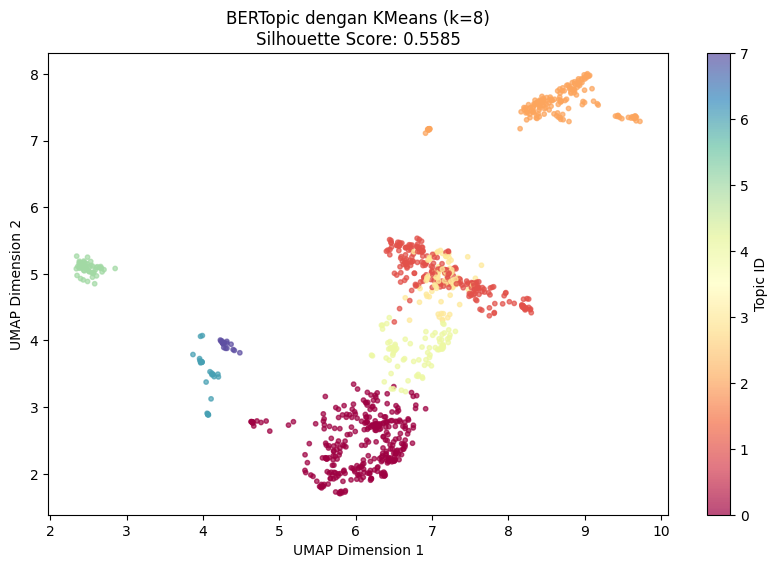

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    umap_embeddings[:,0],
    umap_embeddings[:,1],
    c=topics,
    cmap="Spectral",
    s=10,
    alpha=0.7
)

plt.title(
    f"BERTopic dengan KMeans (k={k_optimal})\n"
    f"Silhouette Score: {sil_score:.4f}"
)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label="Topic ID")
plt.show()
